# Исследование прогнозирование надежности заемщиков

В данном проекте велась работа по исследованию надежности заемщиков. Датасет, который использовался, требовал тщательной предобработки данных, после чего было необходимо проверить гипотезу о влиянии количества детей, семейное положение, уровень дохода и цели заемщика влияют на факт погашения кредита в срок.

Данный проект я доработал, добавив раздел, где проводится исследование работы моделей машинного обучения на таких данных для решения задачи классификации клиентов на добросовестных и потенциальных должников. В этой работе применяются модели LightGBM и логистическая регрессия, а также сравнение их работы на данных со сбалансированным весом классов целевого признака и семплированных при помощи SMOTE данных. 

## Обзор данных

In [1]:
#делаем фундаментальные заявления
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns
import lightgbm          as lgb

from imblearn.over_sampling  import SMOTE 
from imblearn.pipeline       import Pipeline

from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay,\
                                     classification_report, plot_roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing   import OrdinalEncoder, StandardScaler

In [2]:
#сохраним таблицу в переменную df
df = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

In [3]:
#вставим функцию для описания датасета
def exploring(df):
    print('----------- Описание данных -----------')
    display(df.head(20))
    print('---------------------------------------')
    display(df.info())
    print('---------------------------------------')
    display(df.describe().T)
    print('---------------------------------------')
    display(df.describe(include=[object]).T)
    print('---------------------------------------')
    for column in df.columns:
        print('-------------------------')
        print(column,' : кол-во 0:', df[df[column] == 0][column].count(),
        ', процент 0:', round(df[df[column] == 0][column].count()/len(df)*100, 2),'%', 
        ', кол-во NaN:', df[column].isna().sum(), 
        ', процент NaN:', round(df[column].isna().sum()/len(df)*100, 2),'%')
    print('---------------------------------------')
    print('Количество строк-дубликатов:', df.duplicated().sum())

In [4]:
exploring(df)

----------- Описание данных -----------


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


None

---------------------------------------


,count,mean,std,min,25%,50%,75%,max
children,21525.0,0.538908,1.381587,-1.000000,0.000000,0.000000,1.000000,2.000000e+01
days_employed,19351.0,63046.497661,140827.311974,-18388.949901,-2747.423625,-1203.369529,-291.095954,4.017554e+05
dob_years,21525.0,43.293380,12.574584,0.000000,33.000000,42.000000,53.000000,7.500000e+01
education_id,21525.0,0.817236,0.548138,0.000000,1.000000,1.000000,1.000000,4.000000e+00
family_status_id,21525.0,0.972544,1.420324,0.000000,0.000000,0.000000,1.000000,4.000000e+00
debt,21525.0,0.080883,0.272661,0.000000,0.000000,0.000000,0.000000,1.000000e+00
total_income,19351.0,167422.302208,102971.566448,20667.263793,103053.152913,145017.937533,203435.067663,2.265604e+06


---------------------------------------


,count,unique,top,freq
education,21525,15,среднее,13750
family_status,21525,5,женат / замужем,12380
gender,21525,3,F,14236
income_type,21525,8,сотрудник,11119
purpose,21525,38,свадьба,797


---------------------------------------
-------------------------
children  : кол-во 0: 14149 , процент 0: 65.73 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
days_employed  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 2174 , процент NaN: 10.1 %
-------------------------
dob_years  : кол-во 0: 101 , процент 0: 0.47 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
education  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
education_id  : кол-во 0: 5260 , процент 0: 24.44 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
family_status  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
family_status_id  : кол-во 0: 12380 , процент 0: 57.51 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
gender  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
income_type  : кол-во 0: 0 , процент 0: 

Мы имеем потрясающую таблицу с безумными значениями в столбце days_employed, дубликатами в education и purpose, а также замечательной парой пенсионеров из строк №4 и №12, желающих сыграть свадьбу, по всей видимости, друг с другом. 

Если у мужчины из двенадцатой строки и немного шансов на одобрение кредита, то у женщины из четвертой строки, отработавшей 932 года из 53 лет жизни и имеющей шестизначный доход, перспективы не такие туманные.

Кроме того, имеется 10% пропусков в days_employed и total_income.

Причины могут быть разными - данная информация могла по каким-либо причинам отсутствовать как умышленно, так и случайно. 
Возможно клиент не указал данную информацию, или же она не попала в таблицу по ошибке.

Удалим их и забудем их, как страшный сон, они хоть и в разных столбцах, но встречаются в одних и тех же строках. А еще, избавимся от минусов и дубликатов.

In [5]:
# устраняем Nan
df = df.dropna()
# берем модуль
df.days_employed = abs(df.days_employed)
# удаляем дубликаты
df = df.drop_duplicates().reset_index(drop=True)
# проверимся
print('Кол-во дубликатов:', df.duplicated().sum())
df.shape

Кол-во дубликатов: 0


(19351, 12)

Заслуженно. 

Оценим сбалансированность целевого признака. Очевидно, что выборка несбалансирована, не может же кредит возвращаться с вероятностью 50/50.

0    17780
1     1571
Name: debt, dtype: int64


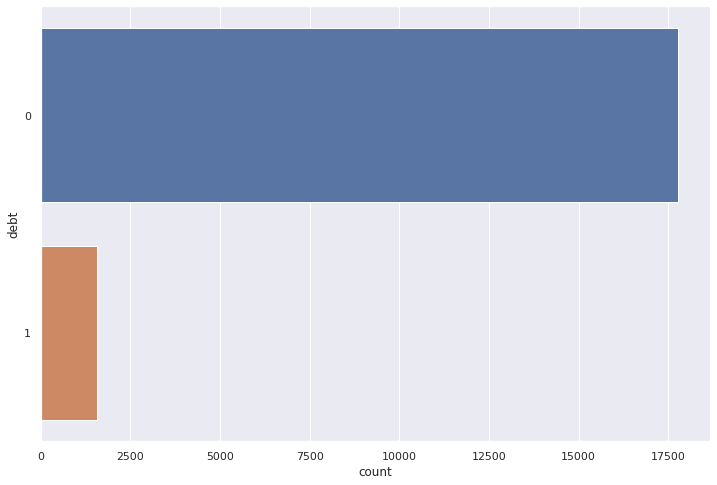

In [6]:
# посчитаем
print(df.debt.value_counts())
# построим график
sns.set(rc={'figure.figsize':(12, 8)})
sns.countplot(y='debt', data=df);

Класс 1 встречается более, чем в 10 раз реже класса 0

## Проверка данных на аномалии.
### Работа со стажем

Теперь попробуем привести данные по стажу к одной размерности. Сопоставим стаж и возраст.

Создадим сводник. Нас интересует минимальное, максимальное и медианное значение стажа для каждого типа занятости, а так же посчитаем количество людей в каждой категории. А еще добавим группу столбцов с минимальным, максимальным и медианным значением возраста, чтобы убедиться, что никто не начал работать еще при царе.

In [7]:
experience_pivot = df\
                    .groupby('income_type')\
                    .agg({'days_employed': ['min', 'max', 'mean', 'median', 'count'], 
                          'dob_years': ['min', 'max', 'median']})
display(experience_pivot)

days_employed                                               \
                           min            max           mean         median   
income_type                                                                   
безработный      337524.466835  395302.838654  366413.652744  366413.652744   
в декрете          3296.759962    3296.759962    3296.759962    3296.759962   
госслужащий          39.954170   15193.032201    3399.896902    2689.368353   
компаньон            30.195337   17615.563266    2111.524398    1547.382223   
пенсионер        328728.720605  401755.400475  365003.491245  365213.306266   
предприниматель     520.848083     520.848083     520.848083     520.848083   
сотрудник            24.141633   18388.949901    2326.499216    1574.202821   
студент             578.751554     578.751554     578.751554     578.751554   

                       dob_years             
                 count       min max median  
income_type                                  
безработный          2        31  45   38.0  
в декрете            1        39  39   39.0  
госслужащий       1312         0  75   40.0  
компаньон         4577         0  74   39.0  
пенсионер         3443         0  74   60.0  
предприниматель      1        27  27   27.0  
сотрудник        10014         0  74   39.0  
студент              1        22  22   22.0

Имеются большие числа стажа. Нужно проверить, их а адекватность

Штош, переведем максимальные значения в года и сравним с максимальным возрастом. Поступим также и с медианой.

Минимальные значения пока сравнивать не будем, в половине случаев в возрасте красуются нули, с ними разберемся позже.

In [8]:
#будь проклят мультииндекс

#разделим на 365 значения в столбце ('days_employed', 'median') и сохраним в стобце ('days_employed', 'median_years')
experience_pivot[[('days_employed', 'median'), ('days_employed', 'max')]] = experience_pivot[[('days_employed', 'median'), 
                                                                                              ('days_employed', 'max')]] / 365
#выведем только столбцы ('days_employed', 'median_years'), ('dob_years', 'median')
display(experience_pivot[[('days_employed', 'median'), 
                          ('days_employed', 'max'), 
                          ('dob_years', 'median'), 
                          ('dob_years', 'max')]])

days_employed              dob_years    
                       median          max    median max
income_type                                             
безработный       1003.873021  1083.021476      38.0  45
в декрете            9.032219     9.032219      39.0  39
госслужащий          7.368132    41.624746      40.0  75
компаньон            4.239403    48.261817      39.0  74
пенсионер         1000.584401  1100.699727      60.0  74
предприниматель      1.426981     1.426981      27.0  27
сотрудник            4.312884    50.380685      39.0  74
студент              1.585621     1.585621      22.0  22

Выглядит правдоподобно.

### Работа с возрастом

Пофиксим нулевой возраст в столбце `dob_years` его, а потом пройдем по столбцам, которые действительно имеют значение для гипотезы.

Начнем с изучения контингента новорожденных.

In [9]:
#Выведем первые пять значений возраста с количеством клиентов
df[df['dob_years'] == 0].groupby('income_type')['debt'].count()

income_type
госслужащий     6
компаньон      18
пенсионер      17
сотрудник      50
Name: debt, dtype: int64

Такой молодой, а уже пенсионер. Можно заменить на медианное значение в соответствии с типом занятости, конечно. Но мы нули удалим, чтобы не загонять в модель придуманные значения.

In [10]:
df = df[df['dob_years'] != 0]
df.shape

(19260, 12)

**Готово!**

### Работа с количеством детей
Займемся настоящим делом - поищем аномалии в количестве детей.

In [11]:
#посмотрим на разнообразие количества детей
df.groupby('children')['debt'].count()

children
-1        44
 0     12649
 1      4328
 2      1838
 3       293
 4        34
 5         8
 20       66
Name: debt, dtype: int64

Занимательные крайности. 

Я погуглил, 20 детей - это не рекорд рождаемости (рекорд - 69 детишек), а вот минус 1 - интересно.

Можно пойти двумя путями: убрать их из таблицы, или принять за опечатку. 

В обоих случаях их количество не может значительно повлиять на результат, но так, как это дети, а не безработные, в таблице мы их оставим, заменив -1 на 1, а 20, например, на 2

children
0    12649
1     4372
2     1904
3      293
4       34
5        8
Name: debt, dtype: int64

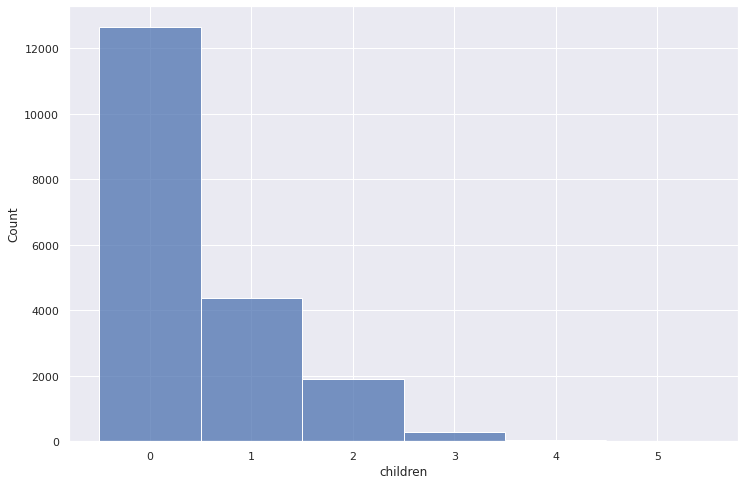

In [12]:
#возводим в абсолют
df['children'] = abs(df['children'])
#напишем цикл, преращающий 20 в 2
for value in df['children']:
    if value == 20:
        df['children'] = df['children'].replace(value, 2)
#чекнем результат
display(df.groupby('children')['debt'].count())

sns.histplot(data=df, x='children', discrete=True);

Великолепно, никто из этой парочки значений не остался без детей.

### Работа с семейным положением
Теперь проверим `family_status`

family_status
Не женат / не замужем     2510
в разводе                 1074
вдовец / вдова             861
гражданский брак          3717
женат / замужем          11098
Name: debt, dtype: int64

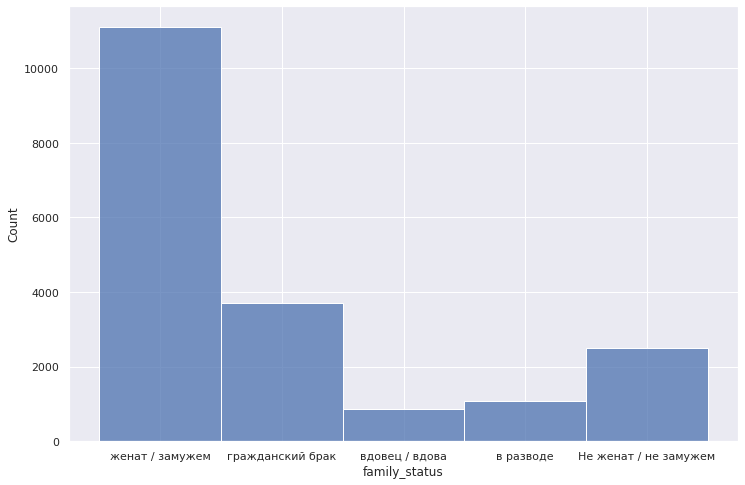

In [13]:
display(df.groupby('family_status')['debt'].count())
sns.histplot(data=df, x='family_status', discrete=True);

Тут все хорошо. 
Проверим и `family_status_id`, все, что угодно может быть

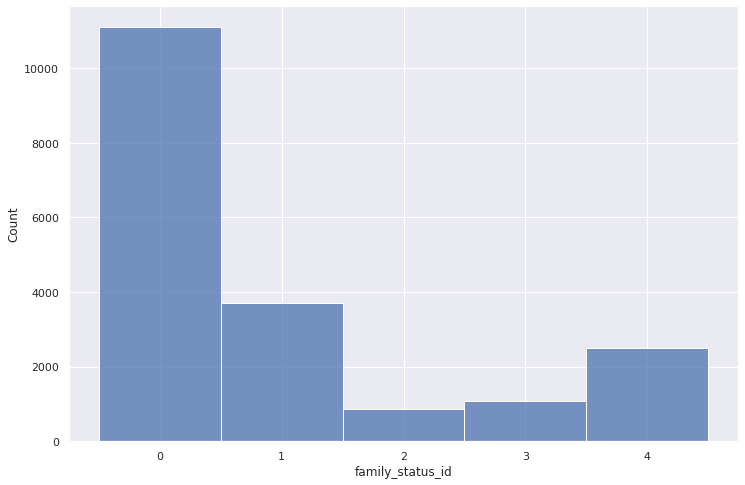

In [14]:
df.groupby('family_status_id')['debt'].count()
sns.histplot(data=df, x='family_status_id', discrete=True);

Можно констатировать отсутствие незамеченных аномалий и двигаться дальше.

## Исправления в данных
### Изменение типов данных.

Шесть цифр после точки - не предел, в числе пи их вообще бесконечное множество.

Пришла пора срезать углы, т.е. округлять значения в `days_employed` и `total_income`.

In [15]:
#начнем с 'days_employed'. Применим метод astype()
df['days_employed'] = round(df['days_employed']).astype('int')
#теперь 'total_income' 
df['total_income'] = round(df['total_income']).astype('int')
#проверим, все ли хорошо
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8438,42,высшее,0,женат / замужем,0,F,сотрудник,0,253876,покупка жилья
1,1,4025,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья
3,3,4125,32,среднее,1,женат / замужем,0,M,сотрудник,0,267629,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


### Неявные дубликаты в уровне образования
Пришло время навести порядок в `education`

In [16]:
#Посмотрим, какие бывают значения в данном столбе
df['education'].sort_values().unique()

array(['ВЫСШЕЕ', 'Высшее', 'НАЧАЛЬНОЕ', 'НЕОКОНЧЕННОЕ ВЫСШЕЕ',
       'Начальное', 'Неоконченное высшее', 'СРЕДНЕЕ', 'Среднее',
       'УЧЕНАЯ СТЕПЕНЬ', 'Ученая степень', 'высшее', 'начальное',
       'неоконченное высшее', 'среднее', 'ученая степень'], dtype=object)

Поправить можно все, а такое - проще простого

In [17]:
df['education'] = df['education'].str.lower()
#проверим, все ли хорошо
df['education'].sort_values().unique()

array(['высшее', 'начальное', 'неоконченное высшее', 'среднее',
       'ученая степень'], dtype=object)

Двигаемся дальше

### Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

Продолжим выполнять сайдквесты, отвлекаясь иногда на основной.

Создадим пару словарей:

`df_education` со столбцами `education_id` и `education`;

`df_family_status`со столбцами `family_status_id` и `family_status`.

In [18]:
#создадим датафрейм df_education
df_education = df[['education_id', 'education']]\
                .drop_duplicates()\
                .reset_index(drop=True)
#проверим что вышло
df_education

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


Очень странный порядок.

In [19]:
#создадим датафрейм df_family_status
df_family_status = df[['family_status_id', 'family_status']]\
                    .drop_duplicates()\
                    .reset_index(drop=True)
#проверим что вышло
df_family_status

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


### Категоризация дохода.

Проведем категоризацию заемщиков по уровню дохода (конечно же для будущих свершений, не для целевой гипотезы).

Распределение следующее:

0–30000 — `E`;

30001–50000 — `D`;

50001–200000 — `C`;

200001–1000000 — `B`;

1000001 и выше — `A`.

In [20]:
#Создадим функцию, которая возвращает группу дохода по значению дохода
def income_group(income):
    if income <= 30000:
        return 'E'
    if income <= 50000:
        return 'D'
    if income <= 200000:
        return 'C'
    if income <= 1000000:
        return 'B'
    return 'A'

#Теперь внесем оценку дохода в таблицу
df['total_income_category'] = df['total_income'].apply(income_group)
display(df.head(20))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,8438,42,высшее,0,женат / замужем,0,F,сотрудник,0,253876,покупка жилья,B
1,1,4025,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья,C
3,3,4125,32,среднее,1,женат / замужем,0,M,сотрудник,0,267629,дополнительное образование,B
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255764,покупка жилья,B
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240526,операции с жильем,B
7,0,153,50,среднее,1,женат / замужем,0,M,сотрудник,0,135824,образование,C
8,2,6930,35,высшее,0,гражданский брак,1,F,сотрудник,0,95857,на проведение свадьбы,C
9,0,2189,41,среднее,1,женат / замужем,0,M,сотрудник,0,144426,покупка жилья для семьи,C


Клиентов клеймили, пора заняться их целями.

###  Категоризация целей кредита.

Начнем со знакомства с, непосредственно, целями.

In [21]:
df['purpose'].sort_values().unique()

array(['автомобили', 'автомобиль', 'высшее образование',
       'дополнительное образование', 'жилье',
       'заняться высшим образованием', 'заняться образованием',
       'на покупку автомобиля', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля', 'на проведение свадьбы',
       'недвижимость', 'образование', 'операции с жильем',
       'операции с коммерческой недвижимостью',
       'операции с недвижимостью', 'операции со своей недвижимостью',
       'покупка жилой недвижимости', 'покупка жилья',
       'покупка жилья для сдачи', 'покупка жилья для семьи',
       'покупка коммерческой недвижимости', 'покупка недвижимости',
       'покупка своего жилья', 'получение высшего образования',
       'получение дополнительного образования', 'получение образования',
       'приобретение автомобиля', 'профильное образование',
       'ремонт жилью', 'свадьба', 'свой автомобиль',
       'сделка с автомобилем', 'сделка с подержанным автомобилем',
       'строительство 

Применим способ, аналогичный категоризации дохода

In [22]:
def purpose_group(purpose):
    if  'авто' in purpose:
        return 'операции с автомобилем'
    elif 'недвиж' in purpose or 'жиль' in purpose:
        return 'операции с недвижимостью'
    elif 'свадьб' in purpose:
        return 'проведение свадьбы'
    return 'получение образования'

df['purpose_category'] = df['purpose'].apply(purpose_group)
df.head(20)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8438,42,высшее,0,женат / замужем,0,F,сотрудник,0,253876,покупка жилья,B,операции с недвижимостью
1,1,4025,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья,C,операции с недвижимостью
3,3,4125,32,среднее,1,женат / замужем,0,M,сотрудник,0,267629,дополнительное образование,B,получение образования
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255764,покупка жилья,B,операции с недвижимостью
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240526,операции с жильем,B,операции с недвижимостью
7,0,153,50,среднее,1,женат / замужем,0,M,сотрудник,0,135824,образование,C,получение образования
8,2,6930,35,высшее,0,гражданский брак,1,F,сотрудник,0,95857,на проведение свадьбы,C,проведение свадьбы
9,0,2189,41,среднее,1,женат / замужем,0,M,сотрудник,0,144426,покупка жилья для семьи,C,операции с недвижимостью


### Удаляем лишнее
Снесем ненужные больше столбцы

In [23]:
to_drop = ['education', 'family_status', 'purpose']
df = df.drop(to_drop, axis=1)
df.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,total_income_category,purpose_category
0,1,8438,42,0,0,F,сотрудник,0,253876,B,операции с недвижимостью
1,1,4025,36,1,0,F,сотрудник,0,112080,C,операции с автомобилем
2,0,5623,33,1,0,M,сотрудник,0,145886,C,операции с недвижимостью
3,3,4125,32,1,0,M,сотрудник,0,267629,B,получение образования
4,0,340266,53,1,1,F,пенсионер,0,158616,C,проведение свадьбы


Марафет навели, займемся гипотезой

### Ответы на вопросы.

##### Вопрос 1:

Есть ли зависимость между количеством детей и возвратом кредита в срок?

Сейчас узнаем!

In [24]:
#посчитаем долю должников в зависимости от количества детей
df_q1 = df.pivot_table(index='children', 
                       values='debt', 
                       aggfunc=['mean', 'count'])
df_q1

,mean,count
,debt,debt
children,,
0,0.074868,12649
1,0.092864,4372
2,0.097164,1904
3,0.075085,293
4,0.088235,34
5,0.000000,8


Можно было бы сказать, что самые надежные заемщики - люди с пятью детьми, но в нашей выборке их всего 8 человек и разумно брать уровень значимости в 5%. Значения в остальных категориях различаются несильно, хотя люди без детей выглядят на фоне остальных лучше всех.

##### Вывод 1:

Прослеживается едва заметная зависимость - клиенты без детей возвращают кредиты чаще других. Многодетные родители с тремя детьми стараются конкурировать с бездетными. У остальных ситуация с возвратом кредитов значительно хуже.

##### Вопрос 2:

Есть ли зависимость между семейным положением и возвратом кредита в срок?

Чекнем!

In [25]:
#посчитаем долю должников в зависимости от семейного положения
df_q2 = df.pivot_table(index=['family_status_id'], 
                       values='debt', 
                       aggfunc=['mean', 'count'])
df_q2

,mean,count
,debt,debt
family_status_id,,
0,0.075870,11098
1,0.090665,3717
2,0.063879,861
3,0.070764,1074
4,0.100797,2510


И снова различия небольшие, но есть. 

##### Вывод 2:

Вдовы/вдовцы - более надежные заемщики. Они имеют долги по кредитам в 6.5% случаев, против 7% у разведенных, 7.5% у женатых/замужних, 9% у людей в гражданском браке и почти 10% у неженатых/ незамужних 

##### Вопрос 3:

Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Посмотрим!

In [26]:
#доля дожников в зависимости от уровня дохода
df_q3 = df.pivot_table(index=['total_income_category'],
                       values='debt', 
                       aggfunc=['mean', 'count'])
df_q3

,mean,count
,debt,debt
total_income_category,,
A,0.080000,25
B,0.070788,5015
C,0.085415,13850
D,0.060345,348
E,0.090909,22


Опять различия небольшие, но есть - и то хорошо!

##### Вывод 3:

Люди с доходом 30001-50000 самые надежные заемщики. Непогашенных задолденностей у них - 6% от общих.

На втором месте 200001–1000000 с 7% невозвращенных долгов. 

Хуже всех дела обстоят у лиц с доходом 0–30000 - 9% имеют задолженности.

##### Вопрос 4:

Как разные цели кредита влияют на его возврат в срок?

Интересно!

In [27]:
#доля должников в зависимости от цели кредита
df_q4 = df.pivot_table(index=['purpose_category'], 
                       values='debt', 
                       aggfunc=['mean', 'count'])
display(df_q4)

,mean,count
,debt,debt
purpose_category,,
операции с автомобилем,0.093935,3875
операции с недвижимостью,0.073259,9719
получение образования,0.092484,3579
проведение свадьбы,0.074748,2087


Ну, хотя бы цели кредита распределены более-менее равномерно.

##### Вывод 4

На операции с недвижимостью приходится 7% задолженностей, примерно столько же - на проведение свадьбы, 9% - на образование. Самыми ненадежными заемщиками являются покупатели автомобилей - 9.4% непогашенных задолженностей.

## Вывод по гипотезам:

В ходе исследования был сформирован портрет наиболее надежного заемщика.

Он не должен иметь детей, быть вдовой или вдовцом, иметь доход 30-50 тыс. и брать займ на операции с недвижимостью.

Если тянет на риск, хочется поспорить с коллегами и сделать ставки - отличным вариантом будет дать кредит неженатому клиенту с четырьмя детьми, доходом до 30000 и желанием приобрести машину. Впрочем, нужно ли для этого исследование)

## Построение модели прогнозирования задолженности по кредиту

### Подготовка к обучению
В данной работе я планирую сравнить результаты, полученнные при помощи модели градиентного бустинга LightGBM с прогнозами логистической регрессии/

Начнем с кодирования признаков

In [28]:
encoder = OrdinalEncoder(dtype=int) 

encoder.fit(df[['gender', 'income_type', 
                'total_income_category', 'purpose_category']])
df[['gender', 'income_type', 'total_income_category', 'purpose_category']] = encoder\
                                                                            .transform(df[['gender', 'income_type', 
                                                                                           'total_income_category', 'purpose_category']])

df.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,total_income_category,purpose_category
0,1,8438,42,0,0,0,6,0,253876,1,1
1,1,4025,36,1,0,0,6,0,112080,2,0
2,0,5623,33,1,0,1,6,0,145886,2,1
3,3,4125,32,1,0,1,6,0,267629,1,2
4,0,340266,53,1,1,0,4,0,158616,2,3


Проверим, есть ли мультиколлениарные фичи в нашем датасете

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,total_income_category,purpose_category
children,1.000000,-0.237461,-0.318836,-0.025630,-0.159960,0.043622,0.062582,0.026377,0.031188,-0.021050,-0.002377
days_employed,-0.237461,1.000000,0.608838,0.080110,0.003051,-0.154378,-0.211316,-0.049040,-0.135894,0.134728,-0.001110
dob_years,-0.318836,0.608838,1.000000,0.062494,-0.069450,-0.134667,-0.131251,-0.073309,-0.055998,0.062594,-0.003924
education_id,-0.025630,0.080110,0.062494,1.000000,0.011848,0.029964,0.092977,0.052422,-0.179046,0.145601,-0.002150
family_status_id,-0.159960,0.003051,-0.069450,0.011848,1.000000,-0.037337,-0.004596,0.022680,-0.008970,0.000105,0.002425
gender,0.043622,-0.154378,-0.134667,0.029964,-0.037337,1.000000,0.075761,0.055963,0.179402,-0.160303,-0.008489
income_type,0.062582,-0.211316,-0.131251,0.092977,-0.004596,0.075761,1.000000,0.047981,-0.099441,0.076786,0.012445
debt,0.026377,-0.049040,-0.073309,0.052422,0.022680,0.055963,0.047981,1.000000,-0.012421,0.017956,-0.007688
total_income,0.031188,-0.135894,-0.055998,-0.179046,-0.008970,0.179402,-0.099441,-0.012421,1.000000,-0.742563,-0.009689
total_income_category,-0.021050,0.134728,0.062594,0.145601,0.000105,-0.160303,0.076786,0.017956,-0.742563,1.000000,0.009319


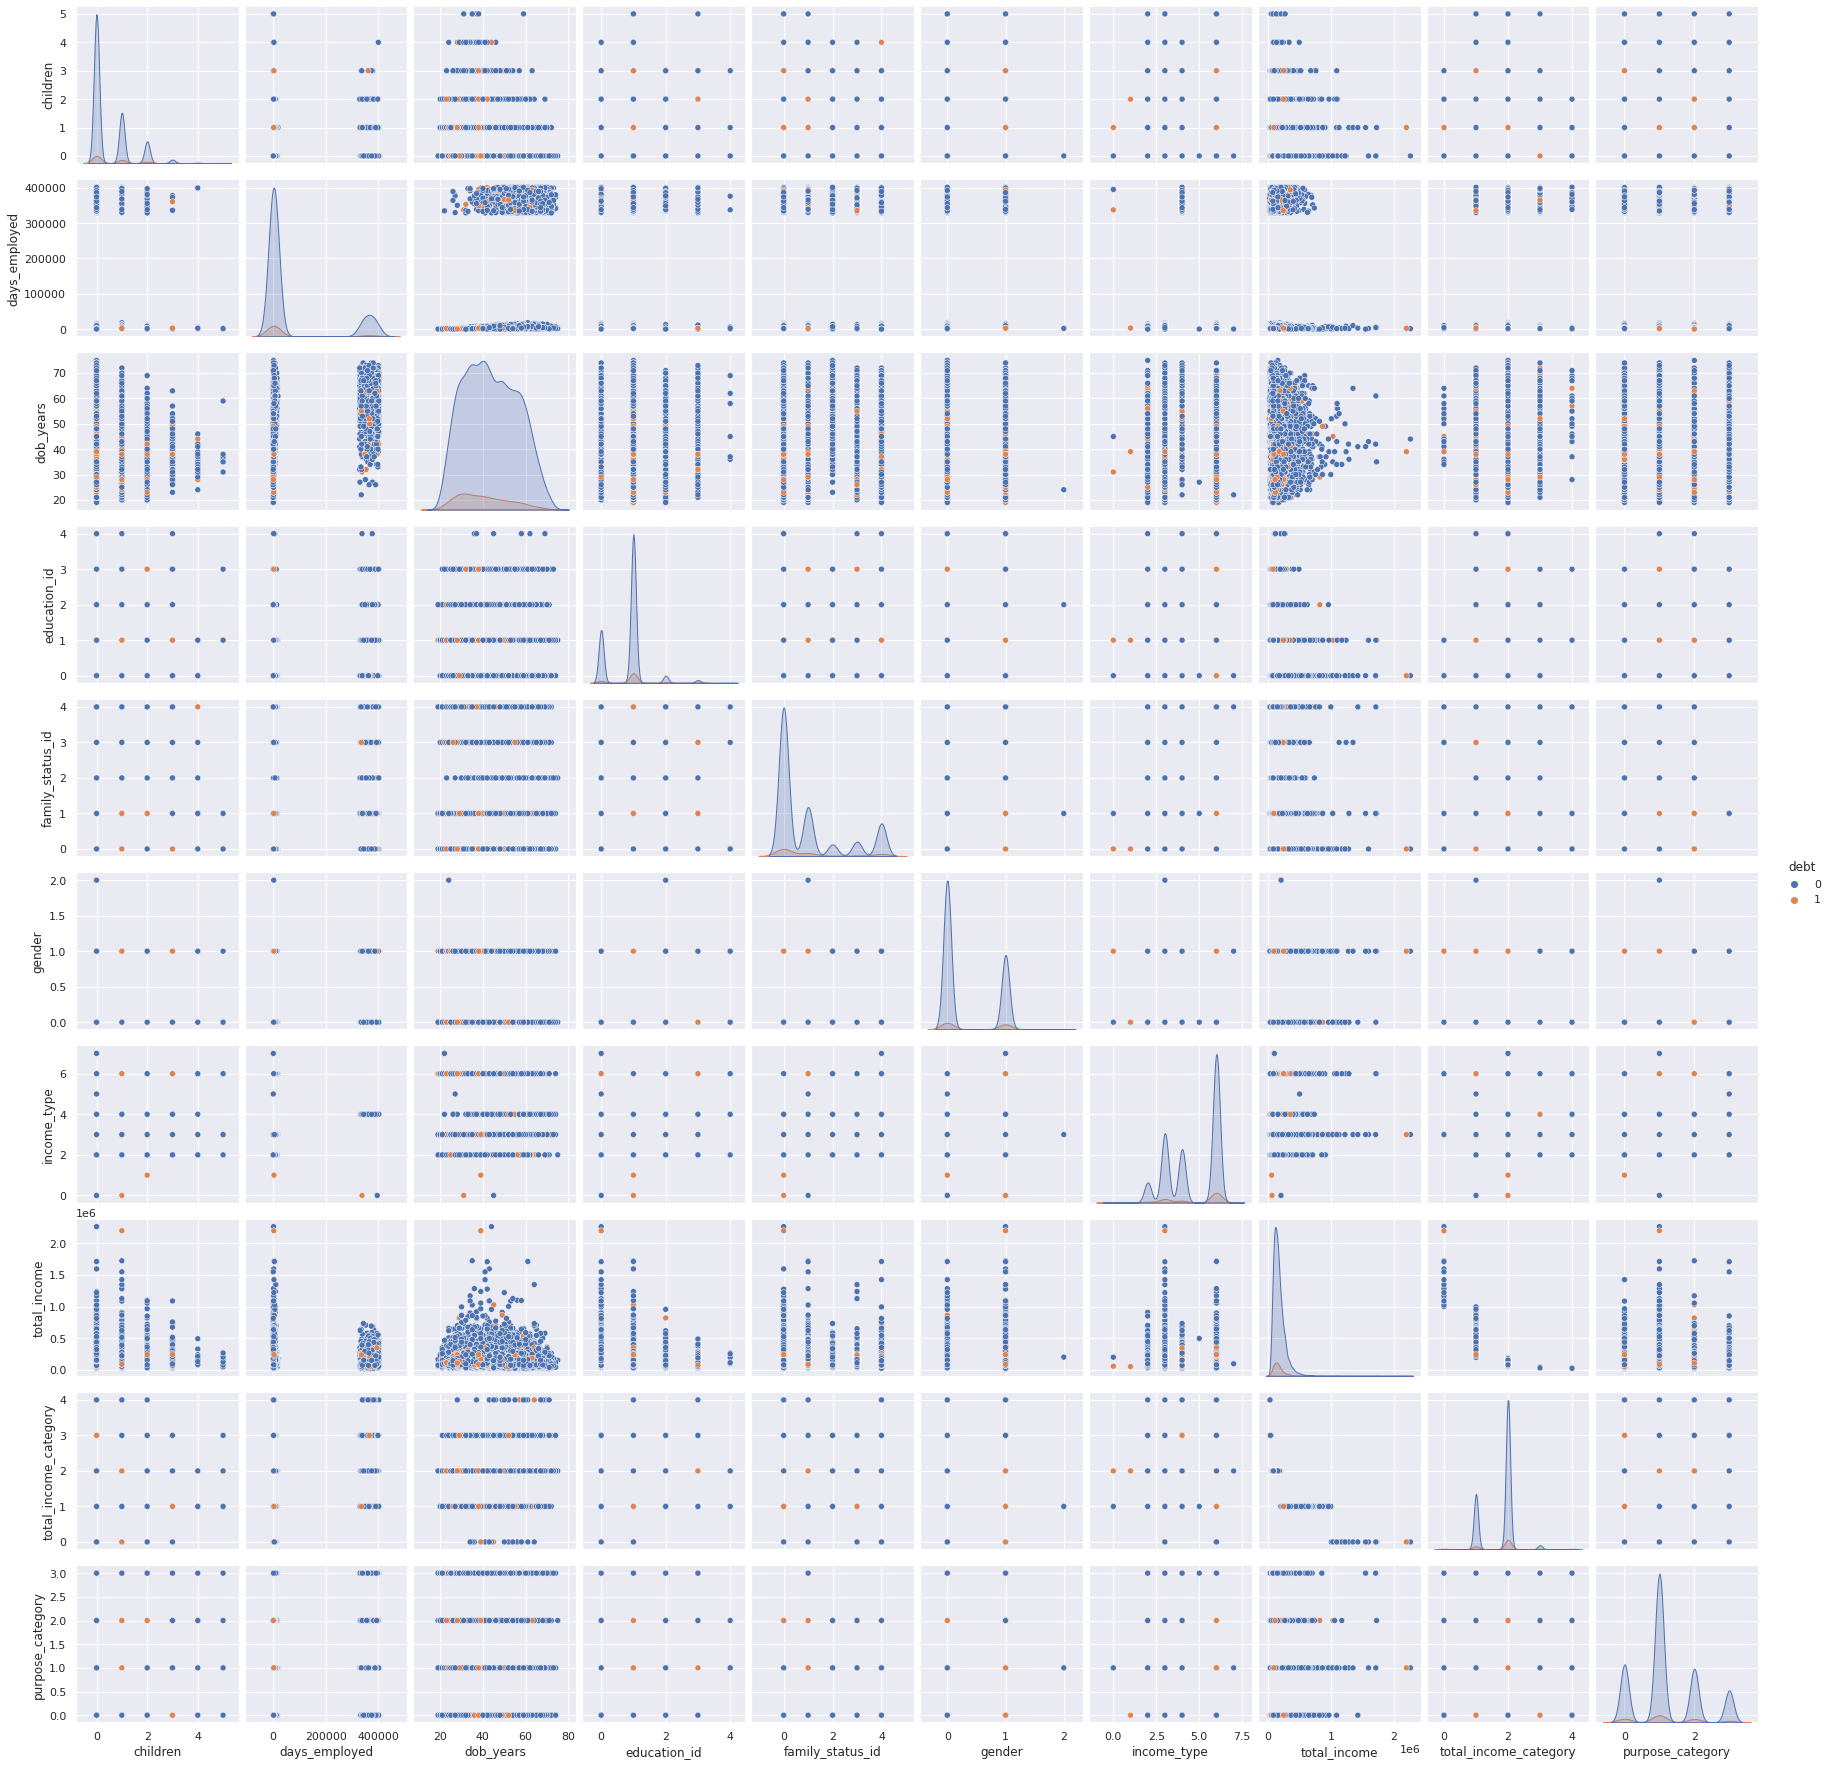

In [29]:
display(df.corr())
sns.pairplot(df, hue='debt');

Имеется явная взаимосвязь возраста и трудового стажа, и это ожидаемо.

Определимся с фичами и таргетом

In [30]:
X = df.drop('debt', axis=1)
y = df.debt
X.shape, y.shape

((19260, 10), (19260,))

Обозначим категориальные фичи для LGBM

In [31]:
cat_features = ['education_id', 'family_status_id', 
                'gender', 'income_type', 
                'total_income_category', 'purpose_category']

Разделим датасет на тренировочный и тестовый. Тестовый будет составлять 0.2 от общего

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15408, 10), (3852, 10), (15408,), (3852,))

Отскалируем вещественные признаки

In [33]:
scaler = StandardScaler()
scaler.fit_transform(X_train[['days_employed', 
                              'dob_years', 
                              'total_income']])
scaler.transform(X_test[['days_employed', 
                         'dob_years', 
                         'total_income']])

array([[-0.46711082, -0.03247298, -0.49304752],
       [-0.47463175, -1.25540832, -0.69624354],
       [ 2.2832801 ,  1.27199139, -0.61528501],
       ...,
       [ 2.38938716,  1.51657846, -0.84259533],
       [-0.47440123, -1.09235027, -0.96840283],
       [-0.47770064, -0.76623418,  0.30327639]])

Отправляемся на подиум

### Dummy-модель
Чтобы от чего-то отталкиваться при сравнении, посмотрим на метрики, получаеммые дамми моделью, которая все проставляет наиболее часто встречающийся класс - 0.

Объявим модель и обучим ее

In [34]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

Сохраним предсказания

In [35]:
dummy_pred = dummy_clf.predict(X_test)

Напишем функцию для вывода необходимых нам метрик - accuracy, precision, recall, F1, ROC AUC. Выведем результаты

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3536
           1       0.00      0.00      0.00       316

    accuracy                           0.92      3852
   macro avg       0.46      0.50      0.48      3852
weighted avg       0.84      0.92      0.88      3852



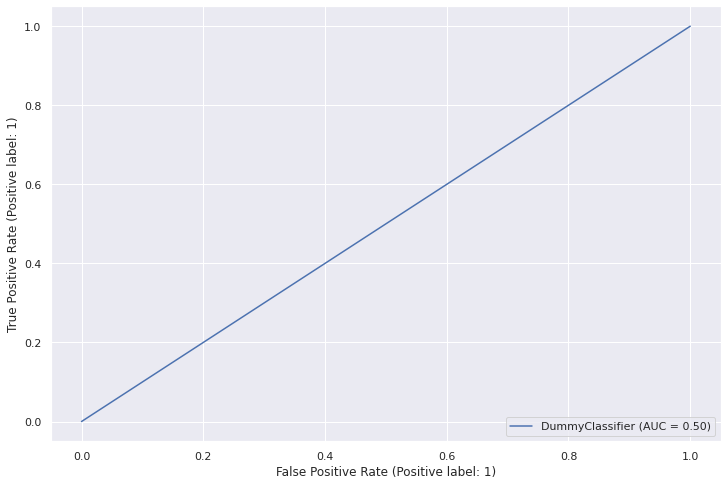

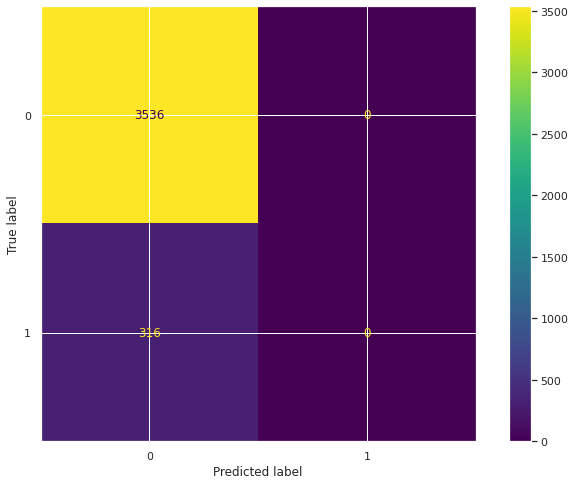

In [36]:
def scoring(model, prediction):
    print(classification_report(y_test, prediction))
    plot_roc_curve(model, X_test, y_test); 
    
    cm = confusion_matrix(y_test, prediction, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()

    plt.show()
    
scoring(dummy_clf, dummy_pred)

Метрики для класса 0 восхитительны, точность - 92. Хорошая была бы модель, если бы не наши цели.

### LightGBM

Построим модель градиентного бустинга, используя LightGBM.

Начнем с создания тренировочного датасета

In [37]:
dtrain_lgb = lgb.Dataset(X_train, 
                         y_train,
                         categorical_feature=cat_features)

Создадим словарь параметров. Усилим вес первого класса

In [38]:
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'num_leaves': 4,
        'max_depth': 2,
        'class_weight': 'balanced'
    }

Определим на кросс-валидации число раундов

In [39]:
cv_data = lgb.cv(params, 
                 dtrain_lgb, 
                 categorical_feature = cat_features, 
                 verbose_eval=False)
cv_data

[LightGBM] [Warning] Unknown parameter: class_weight


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


{'binary_logloss-mean': [0.28016181785885674,
  0.2794218015581473,
  0.2789141238360707,
  0.27851730599305025,
  0.27804139945980466,
  0.27767449510567055,
  0.2773306137165131,
  0.2770677465662172,
  0.2767913427684948,
  0.2765215371614221,
  0.27628958267306303,
  0.276121677970034,
  0.27591453069804894,
  0.27575872654220246,
  0.2755993146549801,
  0.2754428369211889,
  0.2753164914955509,
  0.2751287741919856,
  0.2750842295992882,
  0.27497691819320985,
  0.27490448373132365,
  0.2748320825134064,
  0.274718975846885,
  0.27465823496225655,
  0.2746185177329084,
  0.2745676255570635,
  0.27451496708381373,
  0.27452968868660166,
  0.274498138405797,
  0.2744732154352886,
  0.2744378796690391,
  0.27440616696808645,
  0.2743685108662758,
  0.2743414484646368,
  0.27430156190232313,
  0.27433689163442543,
  0.2743188412794882,
  0.2743293322701601,
  0.27430447351038534,
  0.2742815857787811,
  0.2743265135734744,
  0.27432719010670986,
  0.27432647112580044,
  0.274346623802

Посмотрим на результат

In [40]:
cv_data = np.array(cv_data['binary_logloss-mean'])
print(np.argmin(cv_data))

39


Создадим переменную с моделью, в гипермараметры добавим число раундов, равное 40

In [41]:
lgb_model = lgb.LGBMClassifier(**params, num_boost_round=40)

Обучим модель

In [42]:
lgb_model.fit(X_train, y_train, verbose=False,  categorical_feature=cat_features)

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier(class_weight='balanced', max_depth=2, metric='binary_logloss',
               num_boost_round=40, num_leaves=4, objective='binary',
               verbosity=-1)

Создадим переменную с пресказаниями и оценим метрики

              precision    recall  f1-score   support

           0       0.95      0.61      0.74      3536
           1       0.12      0.60      0.20       316

    accuracy                           0.61      3852
   macro avg       0.53      0.61      0.47      3852
weighted avg       0.88      0.61      0.70      3852



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


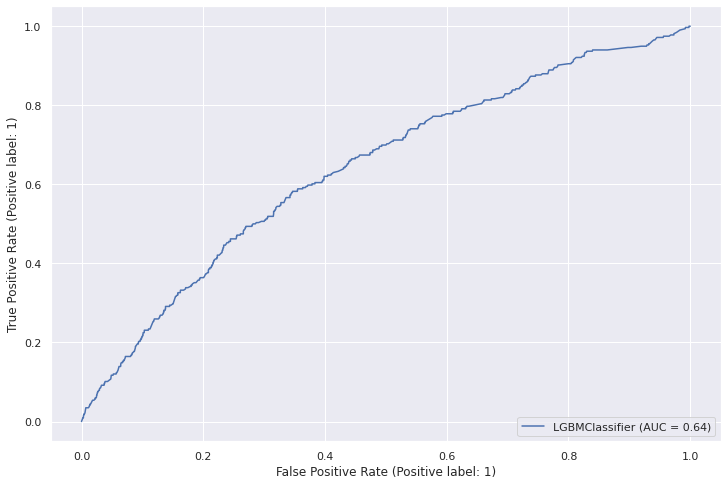

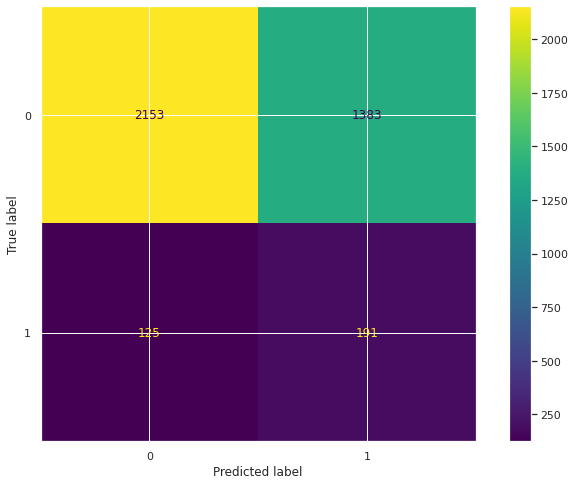

In [43]:
lgb_pred = lgb_model.predict(X_test)
scoring(lgb_model, lgb_pred)

Модель имеет довольно низкую точность, но предсказывает признаки корректно чаще, чем ошибается. Вероятно, здесь игрет роль слабая разница между параметрами, определяющими нулевой и первый класс.

### Логистическая регрессия
Посмотрим, отличается ли результат, полученый при помощи более простой модели. Перебирать гиперпараметры будем гридсерчем. Создадим словарь с сеткой гиперпараметров.

In [44]:
param_grid = {'C': [0.01, 0.1, 1.0, 10, 100],
             'tol': [0.0001, 0.001, 0.01, 0.1, 1]}

Объявим модель

In [45]:
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state = 42)

Пройдемся гридсерчем и выясним наилучшие параметры

In [46]:
grid = GridSearchCV(lr_model, param_grid, scoring='f1')
grid.fit(X_train, y_train)
grid.best_estimator_

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000,
                   random_state=42)

Создадим файл с предсказаниями модели и выведем метрики.

              precision    recall  f1-score   support

           0       0.95      0.20      0.33      3536
           1       0.09      0.90      0.16       316

    accuracy                           0.26      3852
   macro avg       0.52      0.55      0.25      3852
weighted avg       0.88      0.26      0.31      3852



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


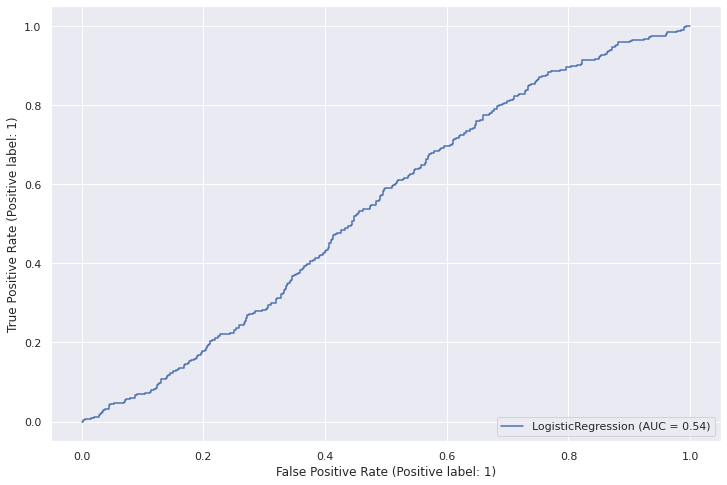

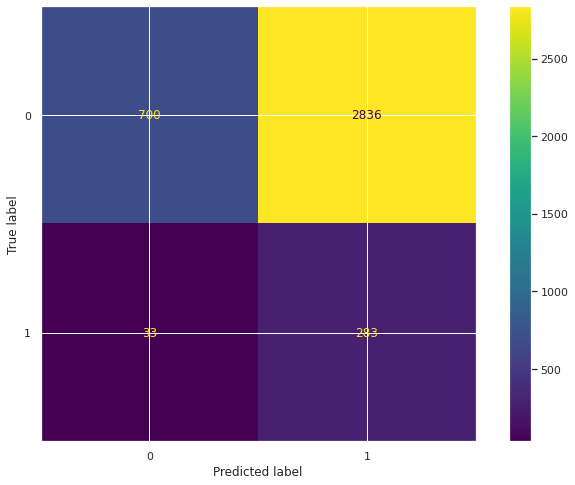

In [47]:
lr_pred = grid.best_estimator_.predict(X_test)
scoring(grid.best_estimator_, lr_pred)

Модель явно планирует обвинить всех в невозврате кредита. Она довольно хорошо справляется с классом 1, но в такой же пропорции считает неблагонадежными и людей без долгов. Действует почти противоположно ранее рассмотренной дамми-модели.

### SMOTE + LightGBM
Сохраним отдельную модель для работы со SMOTE обучим ее на новых признаках

In [48]:
smt = SMOTE(random_state=42)
lgb_pipeline = Pipeline([('smt', smt), ('lgbm', lgb_model)])
lgb_pipeline.fit(X_train, y_train)

[LightGBM] [Warning] num_iterations is set=40, num_boost_round=40 will be ignored. Current value: num_iterations=40


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Pipeline(steps=[('smt', SMOTE(random_state=42)),
                ('lgbm',
                 LGBMClassifier(class_weight='balanced', max_depth=2,
                                metric='binary_logloss', num_boost_round=40,
                                num_leaves=4, objective='binary',
                                verbosity=-1))])

Запилим предсказание и посмотрим на метрики

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      3536
           1       0.10      0.34      0.15       316

    accuracy                           0.69      3852
   macro avg       0.51      0.53      0.48      3852
weighted avg       0.86      0.69      0.75      3852



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


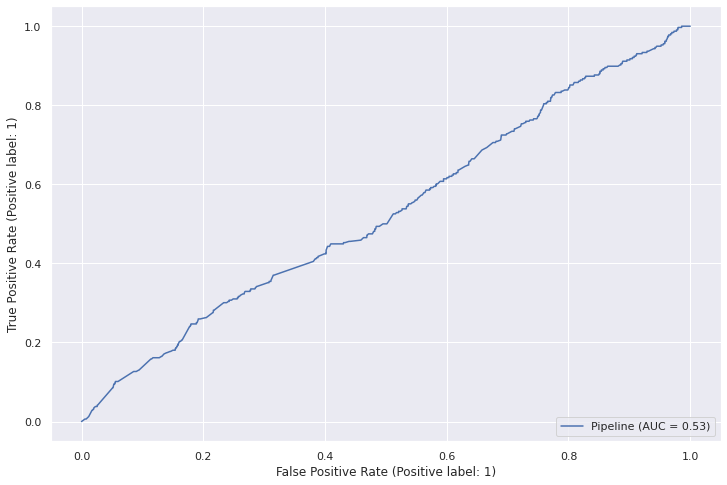

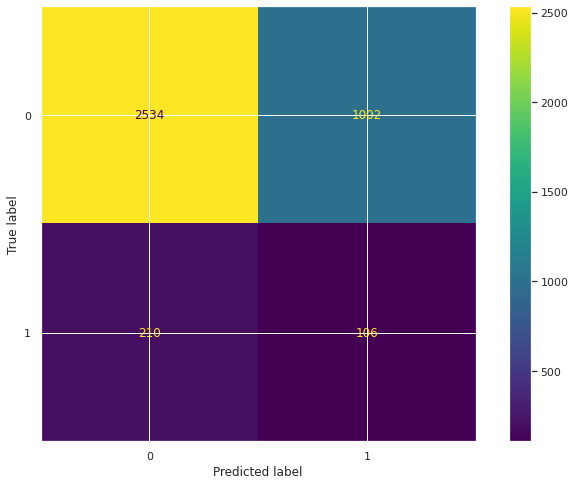

In [49]:
sm_lgb_pred = lgb_pipeline.predict(X_test)
scoring(lgb_pipeline, sm_lgb_pred) 

Несмотря на выросшую метрику accuracy, модель с такими исходными данными справилась с определением потенциальных должников хуже, чем модель с просто отбалансированными весами. Если прошлая модель ошибалась менее, чем в половине случаев, то здесь идет речь о двух третьих.

### SMOTE + Logit
Сделаем то же самое для логистической регрессии.

In [50]:
lr_pipeline = Pipeline([('smt', smt), ('lr', lr_model)])
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('smt', SMOTE(random_state=42)),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

Заценим метрики

              precision    recall  f1-score   support

           0       0.96      0.21      0.34      3536
           1       0.09      0.89      0.17       316

    accuracy                           0.26      3852
   macro avg       0.52      0.55      0.25      3852
weighted avg       0.88      0.26      0.32      3852



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


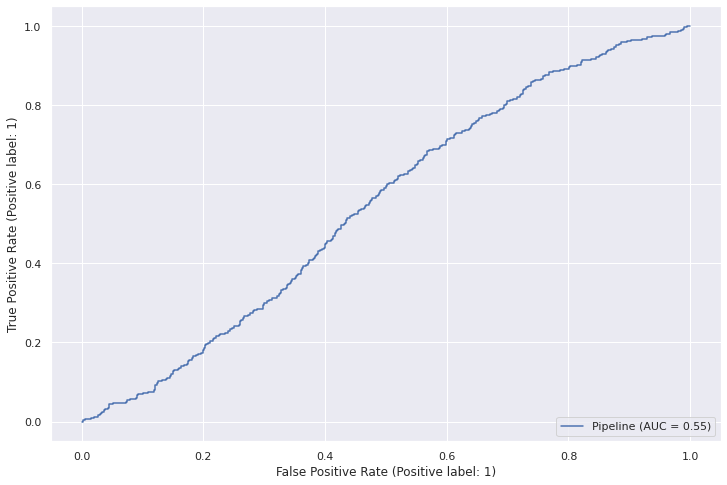

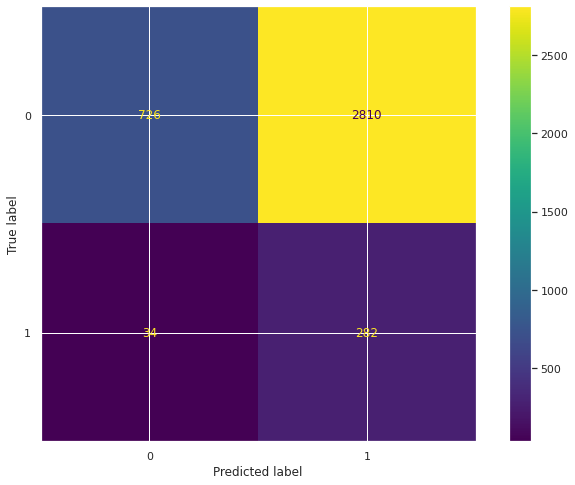

In [51]:
sm_lr_pred = lr_pipeline.predict(X_test)
scoring(lr_pipeline, sm_lr_pred)

Работа логистической регрессии почти не изменилась.

### Вывод построению моделей
Данные в это проекте, помимо очевидного дисбаланса(что нормально), вероятно, слишком слабо различаются, чтобы качественно классифицировать целевой признак(что плохо). В любом случае, работу моделец оуенить можно.
Наилучший результат принесла LightGBM, которая ошибалась с должниками в трети случаев. Почти столько же честных людей она загнала потенциальные должники. Предсказания логистической регрессии вообще носили обвинительный характер. Две трети людей были определены, как ненадежные клиенты. С такой моделью бизнес не построишь. Работа SMOTE положительно на результатах не сказалась.